In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/introextro/train.csv
/kaggle/input/introextro/test.csv


In [2]:
df=pd.read_csv('/kaggle/input/introextro/train.csv')


In [3]:
test_df=pd.read_csv('/kaggle/input/introextro/test.csv')

# Handle missing values

In [4]:
import warnings
from sklearn.impute import SimpleImputer
# Ignore all warnings
warnings.filterwarnings("ignore")
# Impute numerical values with mean
num_cols = df.select_dtypes(include='number').columns
imputer = SimpleImputer(strategy='mean')
df[num_cols] = imputer.fit_transform(df[num_cols])

# Impute categorical values with mode
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)


In [5]:
import warnings
from sklearn.impute import SimpleImputer

# Ignore all warnings
warnings.filterwarnings("ignore")

# --- Assumes you already fitted these during training ---
# imputer_num = SimpleImputer(strategy='mean').fit(train_df[numeric_cols])
# imputer_cat = Mode imputation done manually or handled via pipeline

# 1. Impute numerical columns
num_cols_test = test_df.select_dtypes(include='number').columns

# Use the same numerical imputer from training
test_df[num_cols_test] = imputer.transform(test_df[num_cols_test])

# 2. Impute categorical columns using mode from test_df (if no train mode is available)
cat_cols_test = test_df.select_dtypes(include='object').columns

for col in cat_cols_test:
    if test_df[col].isnull().sum() > 0:
        test_df[col].fillna(test_df[col].mode()[0], inplace=True)


# Encode Categorical Columns


In [6]:
# One-hot encode binary Yes/No columns
from sklearn.preprocessing import LabelEncoder

binary_cols = ['Stage_fear', 'Drained_after_socializing']
df = pd.get_dummies(df, columns=binary_cols, drop_first=True)

# Label encode target variable
le = LabelEncoder()
df['Personality'] = le.fit_transform(df['Personality'])  # e.g., Extrovert=0, Introvert=1

In [7]:
# Ensure same binary columns as in training
binary_cols = ['Stage_fear', 'Drained_after_socializing']

# Apply one-hot encoding to test_df using same structure
# Assume training created: 'Stage_fear_Yes' and 'Drained_after_socializing_Yes'
for col in binary_cols:
    if f"{col}_Yes" not in test_df.columns:
        test_df[f"{col}_Yes"] = 0  # Add missing dummy column if not present

test_df = pd.get_dummies(test_df, columns=binary_cols, drop_first=True)

# Ensure both dummy columns exist (in case one-hot dropped one due to lack of 'Yes')
for expected_col in ['Stage_fear_Yes', 'Drained_after_socializing_Yes']:
    if expected_col not in test_df.columns:
        test_df[expected_col] = 0  # Add missing column with zeros

#  Feature Scaling

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
social_cols = [
    'Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
    'Friends_circle_size', 'Post_frequency'
]
df[social_cols] = scaler.fit_transform(df[social_cols])


In [9]:
test_df[social_cols] = scaler.transform(test_df[social_cols])


# Feature Engineering

In [10]:
df['social_energy_score'] = (
    df['Social_event_attendance'] +
    df['Friends_circle_size'] +
    df['Post_frequency'] +
    df['Going_outside'] -
    df['Time_spent_Alone']
)

df['introversion_ratio'] = df['Time_spent_Alone'] / (df['Friends_circle_size'] + 1e-5)

df['active_socializer'] = (
    (df['Social_event_attendance'] > 0.6) &
    (df['Post_frequency'] > 0.6) &
    (df['Friends_circle_size'] > 0.6)
).astype(int)

# Defensive check for missing columns
drained = df.get('Drained_after_socializing_Yes', pd.Series(0, index=df.index))
fear = df.get('Stage_fear_Yes', pd.Series(0, index=df.index))
df['low_energy_flag'] = (drained & fear).astype(int)


In [11]:
# 1. social_energy_score
test_df['social_energy_score'] = (
    test_df['Social_event_attendance'] +
    test_df['Friends_circle_size'] +
    test_df['Post_frequency'] +
    test_df['Going_outside'] -
    test_df['Time_spent_Alone']
)

# 2. introversion_ratio
test_df['introversion_ratio'] = test_df['Time_spent_Alone'] / (test_df['Friends_circle_size'] + 1e-5)

# 3. active_socializer flag
test_df['active_socializer'] = (
    (test_df['Social_event_attendance'] > 0.6) &
    (test_df['Post_frequency'] > 0.6) &
    (test_df['Friends_circle_size'] > 0.6)
).astype(int)

# 4. low_energy_flag — cleanest and safest version
# Use .filter() to extract only the first matching column
drained_cols = test_df.filter(regex='^Drained_after_socializing_Yes').iloc[:, 0] \
    if test_df.filter(regex='^Drained_after_socializing_Yes').shape[1] > 0 \
    else pd.Series(0, index=test_df.index)

fear_cols = test_df.filter(regex='^Stage_fear_Yes').iloc[:, 0] \
    if test_df.filter(regex='^Stage_fear_Yes').shape[1] > 0 \
    else pd.Series(0, index=test_df.index)

test_df['low_energy_flag'] = (drained_cols.astype(int) & fear_cols.astype(int)).astype(int)

In [12]:
# Defensive get for Drained_after_socializing_Yes
if 'Drained_after_socializing_Yes' in test_df.columns:
    drained = test_df[['Drained_after_socializing_Yes']].iloc[:, 0].astype(int)
else:
    drained = pd.Series(0, index=test_df.index, name='Drained_after_socializing_Yes')

# Defensive get for Stage_fear_Yes
if 'Stage_fear_Yes' in test_df.columns:
    fear = test_df[['Stage_fear_Yes']].iloc[:, 0].astype(int)
else:
    fear = pd.Series(0, index=test_df.index, name='Stage_fear_Yes')

# Create low_energy_flag
test_df['low_energy_flag'] = (drained & fear).astype(int)

# Correlation Matrix

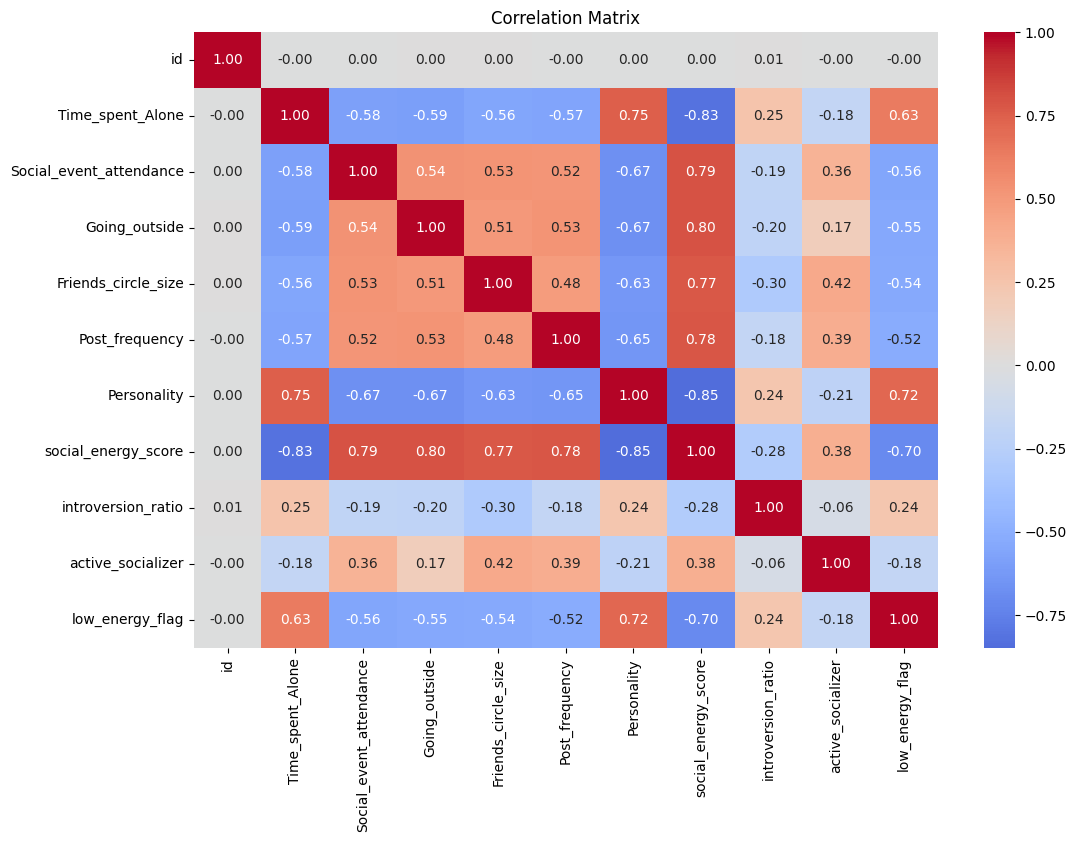

Personality                1.000000
social_energy_score       -0.849728
Time_spent_Alone           0.752916
low_energy_flag            0.722825
Going_outside             -0.674065
Social_event_attendance   -0.673113
Post_frequency            -0.647173
Friends_circle_size       -0.634590
introversion_ratio         0.235022
active_socializer         -0.207069
id                         0.001475
Name: Personality, dtype: float64


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
# Drop constant columns
df_numeric = df.select_dtypes(include='number')
df_numeric = df_numeric.loc[:, df_numeric.nunique() > 1]

# Correlation
corr = df_numeric.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

# Correlation with target
print(corr['Personality'].sort_values(key=abs, ascending=False))


# Model Benchmarking

--Logistic Regression
--Random Forest
--Gradient Boosting Classifier

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=['id', 'Personality'], errors='ignore')
y = df['Personality']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    print(f"\n🔍 {name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(classification_report(y_test, preds, target_names=le.classes_))


🔍 Logistic Regression
              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2740
   Introvert       0.94      0.95      0.95       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705


🔍 Random Forest
              precision    recall  f1-score   support

   Extrovert       0.98      0.97      0.98      2740
   Introvert       0.93      0.95      0.94       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705



In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)
print("🔍 Gradient Boosting Classifier")
print(classification_report(y_test, gb_preds, target_names=le.classes_))


🔍 Gradient Boosting Classifier
              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2740
   Introvert       0.94      0.95      0.94       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705



In [16]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5],
    'subsample': [1.0, 0.8],
    'colsample_bytree': [1.0, 0.8]
}

xgb_grid = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    verbose=2,
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train)

print("✅ Best XGBoost Params:", xgb_grid.best_params_)

best_xgb = xgb_grid.best_estimator_
best_preds = best_xgb.predict(X_test)
print(classification_report(y_test, best_preds, target_names=le.classes_))


Fitting 5 folds for each of 32 candidates, totalling 160 fits
✅ Best XGBoost Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2740
   Introvert       0.94      0.95      0.94       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705



In [17]:
# Remove duplicate columns from test_df
test_df = test_df.loc[:, ~test_df.columns.duplicated()]

In [18]:
# Select only the same features as X_train
X_final_test = test_df[X_train.columns]

# Predict on final test set
final_preds = best_xgb.predict(X_final_test)

# Convert predictions back to original labels
final_labels = le.inverse_transform(final_preds)


In [19]:
# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],              # Ensure 'id' column exists in test_df
    'Personality': final_labels       # Final predicted labels
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("✅ submission.csv saved successfully.")


✅ submission.csv saved successfully.
